# Data Analysis Interview Challenge
#### Relax Challenge - Eleanor Hoyt

### Step 1. Import packages, read in data

In [26]:
# import packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('darkgrid')

In [172]:
# read in users dataset

users_df = pd.read_csv('relax_challenge/takehome_users.csv', encoding = "latin-1")
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
# read in engagement dataset

engage_df = pd.read_csv('relax_challenge/takehome_user_engagement.csv', encoding = "latin-1")
engage_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


We are interested in "adopted users" and the factors that predict user adoption. This problem can be addressed in two phases. 

The first phase will evaluate current user adoption and create a variable that indicates whether a user has adopted or not. This will be evaluated using the engagement dataset and based on the definition of adoption as "a user who has logged into the product on three separate occasions in at least one seven-day period".

The second phase will use the adoption variable as the dependent variable in the users dataset. A classification model will be trained on the user dataset to evaluate factors and attempt to predict future user adoption.

### Step 2. Identifying user adoption

Perform data wranging to create adopted variable.

In [7]:
engage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [10]:
# convert time stamp variable to datetime format

engage_df['time_stamp'] = pd.to_datetime(engage_df['time_stamp'])
engage_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [16]:
# define function to count visits over previous 7 days

def roll7(df):
    return df.rolling(window='7d', on='time_stamp')['visited'].sum()

In [21]:
# apply rolling function to engage df grouped by user id

engage_df['past_7'] = engage_df.groupby('user_id', as_index=False, group_keys=False).apply(roll7)

In [23]:
engage_df.head()

,time_stamp,user_id,visited,past_7
0,2014-04-22 03:53:30,1,1,1.0
1,2013-11-15 03:45:04,2,1,1.0
2,2013-11-29 03:45:04,2,1,1.0
3,2013-12-09 03:45:04,2,1,1.0
4,2013-12-25 03:45:04,2,1,1.0


In [48]:
# created new df of all users and their max number of sign-ins over a 7 day period
# create new categorical variable for adopted

adopted_df = engage_df.groupby('user_id')['past_7'].max()
adopted_df = pd.DataFrame(adopted_df).reset_index()

adopted_df['adopted'] = np.where(adopted['past_7'] >= 3, 1, 0)
adopted_df.head()

,user_id,past_7,adopted
0,1,1.0,0
1,2,3.0,1
2,3,1.0,0
3,4,1.0,0
4,5,1.0,0


In [49]:
adopted_df['adopted'].value_counts()

0    7221
1    1602
Name: adopted, dtype: int64

Of all unique users in the engagement dataset, 7221 users are not considere adopted and 1602 have reached the adopted threshold. Next step will be to combine the new adopted variable into the users dataset.

### Step 3. Wrangle and clean users dataset

In [56]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


Note missing values in last_session_creation_time and invited_by_user_id variables. There are 8,823 non-null values in the last_session variable which is the same number of unique users to engage on the engagement df. This suggests that users who have never engaged may not have a value in the last_session variable. Fill this variable with 0. Simiarly, fill invited by user id with 0 to indicate the user is unknown.

In [51]:
users_df.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [173]:
# fill missing values

users_df['last_session_creation_time'].fillna(0, inplace=True)
users_df['invited_by_user_id'].fillna(0, inplace=True)

users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  12000 non-null  float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          12000 non-null  float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [174]:
# join adopted df
# note that there are 12,000 users but only 8,823 have ever engaged

users_df = users_df.merge(adopted_df, left_on='object_id', right_on='user_id', how='left')


In [175]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  12000 non-null  float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          12000 non-null  float64
 10  user_id                     8823 non-null   float64
 11  past_7                      8823 non-null   float64
 12  adopted                     8823 non-null   float64
dtypes: float64(5), int64(4), object

In [176]:
# drop unnecessary/duplicate columns, fill nans in adopted column with 0

users_df['adopted'].fillna(0, inplace=True)
users_df.drop(columns=['past_7', 'user_id'], inplace=True)

users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  12000 non-null  float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          12000 non-null  float64
 10  adopted                     12000 non-null  float64
dtypes: float64(3), int64(4), object(4)
memory usage: 1.1+ MB


In [177]:
# fix dtypes for datetime variables

# fix creation_time dtype to datetime
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])

# repeat for last session creation time
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'])

In [178]:
# other data cleaning tasks:

# drop name and email variables. 
# could consider feature extraction from these variables in the future, drop for now.
users_df.drop(columns=['name', 'email'], inplace=True)

### Step 4. Some very brief exploratory analysis

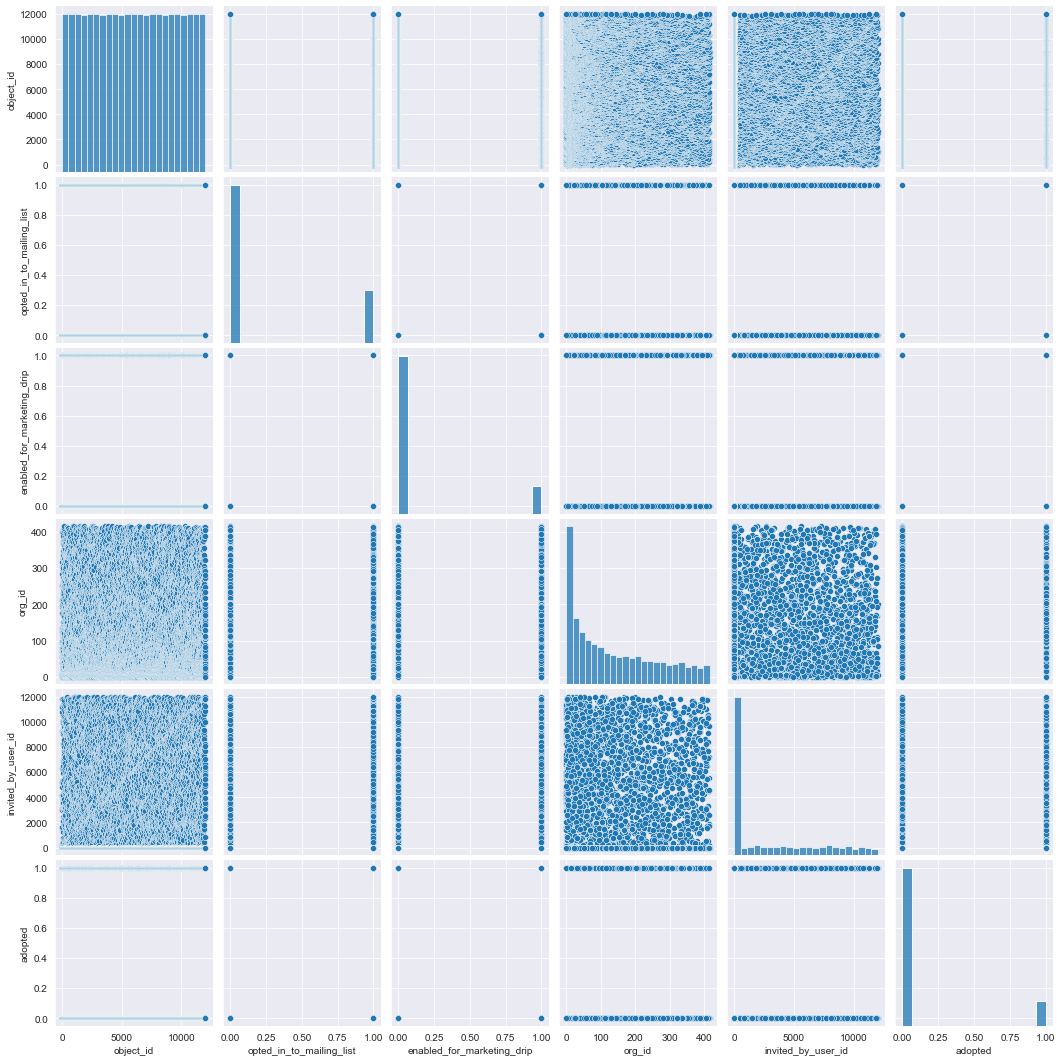

In [180]:
# view pairplot of numerical variables

_ = sns.pairplot(users_df)
plt.show()

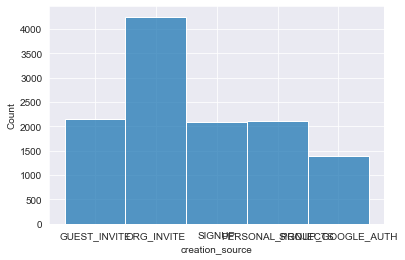

In [179]:
# view histogram of cat variables
_ = sns.histplot(users_df['creation_source'])
plt.show()

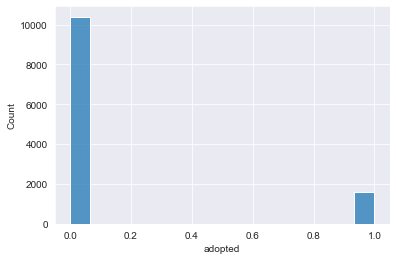

In [188]:
# note imbalanced distribution of dependent variable

_ =sns.histplot(users_df['adopted'].astype(int))
plt.show()

### Step 5. Feature extraction and preprocessing

Extract some features from datetime columns. Get dummy columns for categorical variable.

In [74]:
# extract a few features from creation time variable
users_df['creation_year'] = users_df['creation_time'].dt.year
users_df['creation_month'] = users_df['creation_time'].dt.month
users_df['creation_day'] = users_df['creation_time'].dt.day

# extract a few features from creation time variable, note some missing values here were filled with 0
users_df['last_session_creation_year'] = np.where(users_df['last_session_creation_time'].dt.year == 1970, 0, users_df['last_session_creation_time'].dt.year)
users_df['last_session_creation_month'] = np.where(users_df['last_session_creation_time'].dt.year == 1970, 0, users_df['last_session_creation_time'].dt.month)
users_df['last_session_creation_day'] = np.where(users_df['last_session_creation_time'].dt.year == 1970, 0, users_df['last_session_creation_time'].dt.day)

In [76]:
# drop datetime columns
users_df.drop(columns=['creation_time', 'last_session_creation_time'], inplace=True)

In [77]:
# create dummy columns for creation_source categorical variable
users_df = pd.get_dummies(users_df)

# check dataframe
users_df.head()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_year,creation_month,creation_day,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,last_session_creation_year,last_session_creation_month,last_session_creation_day
0,1,1,0,11,10803.0,0.0,2014,4,22,1,0,0,0,0,0,0,0
1,2,0,0,1,316.0,1.0,2013,11,15,0,1,0,0,0,0,0,0
2,3,0,0,94,1525.0,0.0,2013,3,19,0,1,0,0,0,0,0,0
3,4,0,0,1,5151.0,0.0,2013,5,21,1,0,0,0,0,0,0,0
4,5,0,0,193,5240.0,0.0,2013,1,17,1,0,0,0,0,0,0,0


Get train/test/split datasets and separate dependent variable

In [134]:
from sklearn.model_selection import train_test_split

# create X and y variables, split into train and test sets

X = users_df.drop(columns=['adopted'])
y = users_df['adopted'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

In [80]:
from sklearn.preprocessing import StandardScaler

# train scaler on train set, transform train and test sets

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Step 6. Modeling: Logistic Regression

This is a binary classification problem where we are trying to predict the adopting dependent variable. There are many different types of model to try. For this case, we will use a basic logistic regression model.

In [137]:
from sklearn.linear_model import LogisticRegression

# initiate model object with default parameters
model = LogisticRegression()

# fit model to training set
model.fit(X_train_scaled, y_train)

# predict on test set

y_pred = model.predict(X_test_scaled)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [138]:
# evaluate model performance with accuracy and f1 score metrics

test_acc = model.score(X_test_scaled, y_test)
train_acc = model.score(X_train_scaled, y_train)

from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred)

print('Test accuracy:', test_acc)
print('Train accuracy:', train_acc)
print('F1 Score:', f1)

Test accuracy: 0.866
Train accuracy: 0.8666666666666667
F1 Score: 0.0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


While the accuracy looks okay at 0.86, the f1 score is zero. This may indicate that the model is unable to predict any adopted users, note that the classes are imbalanced.

In [139]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      2598
           1       0.00      0.00      0.00       402

    accuracy                           0.87      3000
   macro avg       0.43      0.50      0.46      3000
weighted avg       0.75      0.87      0.80      3000



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [124]:
# try adding weights to classes to adjust for imbalance

weights = {0.0: 15, 1.0:85}

# initiate model object with default parameters
model = LogisticRegression(class_weight=weights)

# fit model to training set
model.fit(X_train_scaled, y_train)

# predict on test set

y_pred = model.predict(X_test_scaled)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [125]:
# evaluate model performance with accuracy and f1 score metrics

test_acc = model.score(X_test_scaled, y_test)
train_acc = model.score(X_train_scaled, y_train)

from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred)

print('Test accuracy:', test_acc)
print('Train accuracy:', train_acc)
print('F1 Score:', f1)

Test accuracy: 0.661
Train accuracy: 0.6594444444444445
F1 Score: 0.2832980972515856


Some improvement in F1 score, but accuracy decreased. We can try hyperparameter tuning, but this is unlikely to show significant increase in metrics.

In [145]:
# try hyperparameter tuning with grid search CV

model = LogisticRegression()

from sklearn.model_selection import GridSearchCV

param_grid = {
    'C' : [10, 1.0, 0.1],
    'penalty': ['l1', 'l2'], 
}

model_CV = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
model_CV.fit(X_train_scaled, y_train)

model_CV.best_params_

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

{'C': 10, 'penalty': 'l1'}

In [146]:
# train model using best parameters:

model = LogisticRegression(penalty='l1', C=10)

model.fit(X_train_scaled, y_train)
y_pred=model.predict(X_test_scaled)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [147]:
# evaluate model performance with accuracy and f1 score metrics

test_acc = model.score(X_test_scaled, y_test)
train_acc = model.score(X_train_scaled, y_train)

f1 = f1_score(y_test, y_pred)

print('Test accuracy:', test_acc)
print('Train accuracy:', train_acc)
print('F1 Score:', f1)

Test accuracy: 0.866
Train accuracy: 0.8666666666666667
F1 Score: 0.0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [168]:
# identify coefficients

coefs = model.coef_
coefs_df = pd.DataFrame(coefs, columns=X.columns).T

coefs_df.reset_index(inplace=True)
coefs_df.sort_values(by = 0, ascending=False)

,index,0
3,org_id,0.203895
12,creation_source_SIGNUP_GOOGLE_AUTH,0.081085
4,invited_by_user_id,0.038598
8,creation_source_GUEST_INVITE,0.028488
1,opted_in_to_mailing_list,0.019236
0,object_id,0.013744
2,enabled_for_marketing_drip,0.001735
11,creation_source_SIGNUP,0.000000
13,last_session_creation_year,0.000000
14,last_session_creation_month,0.000000


Based on this logistic regression model, the variables org_id and sign_up_google_auth have the largest positive influence over user adoption. Conversely, personal_projects and creation_year have the largest negative influence over user adoption.

### Further steps

This logistic regression model did not perform particularly well. However, we were able to derive some meaning and interpretation from the results. There is a lot of room for improvement here.

In particular, further investigation of the model's performance is key. As well as exploring areas for further feature engineering to derive as much information as possible from these data. 

See accompanying write up for further discussion.

In [ ]:
notes: 
    more EDA
    other feature extraction from name/email columns, from time of engagement in engagement dataset
    more model selection! check for error